# scrambling mechanism

In [242]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector, DensityMatrix, random_statevector, partial_trace

from scipy.special import sph_harm
from scipy.linalg import sqrtm
import pandas as pd
import pickle

import numpy as np
import secrets, time, uuid, hashlib, random

In [397]:
# generate randomized statevectors for testing 
num_wavefunctions = 32
num_qubits = 4 
wave_functions = []

i = 0 
while i < num_wavefunctions: 
    wave_functions.append(random_statevector(dims = 2))
    i += 1

# grouping num_qubits qubits together 
quotient = num_wavefunctions // num_qubits

groups = []

i = 0
while i < num_wavefunctions: 
    groups.append([wave_functions[i:i+num_qubits]])
    i += num_qubits


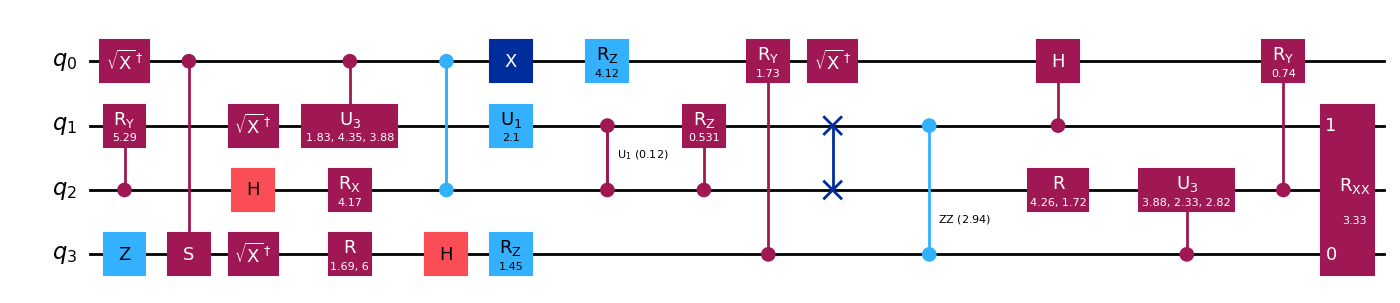

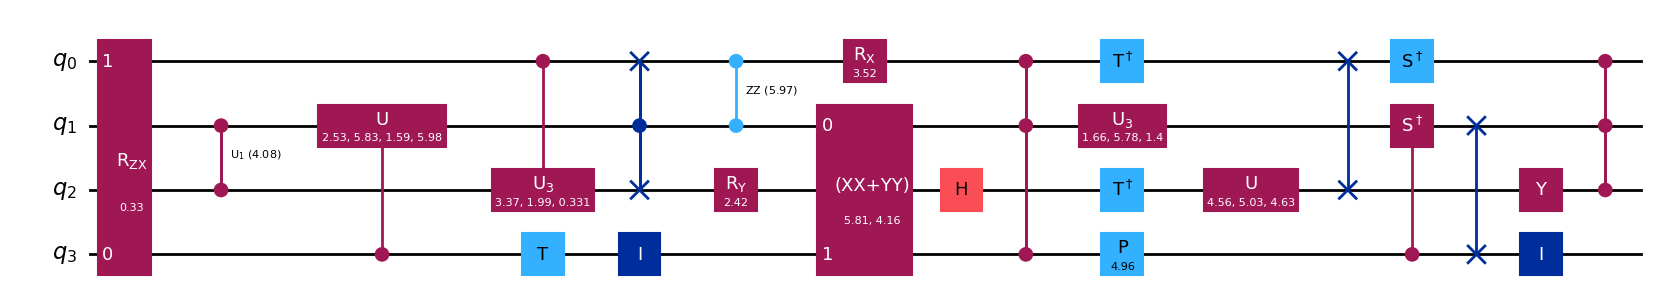

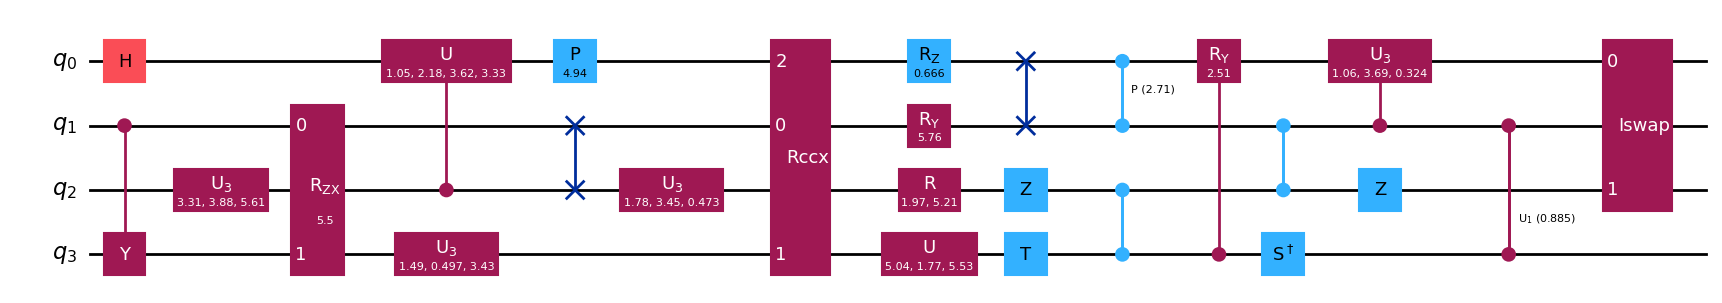

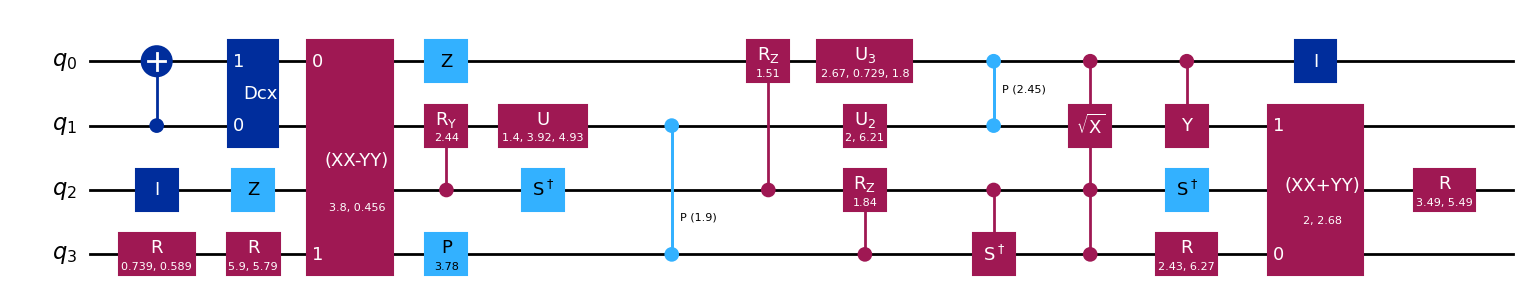

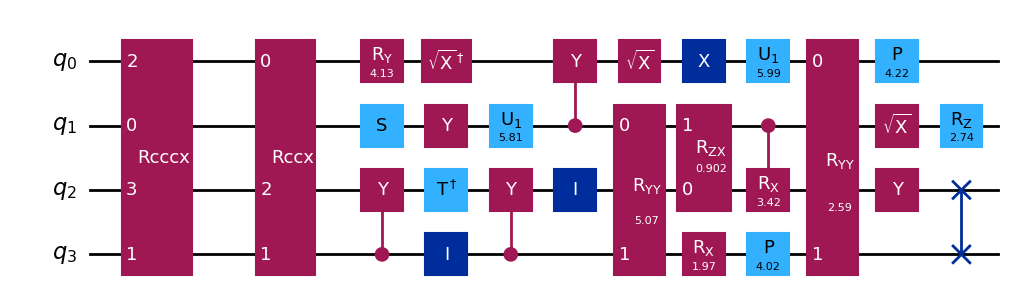

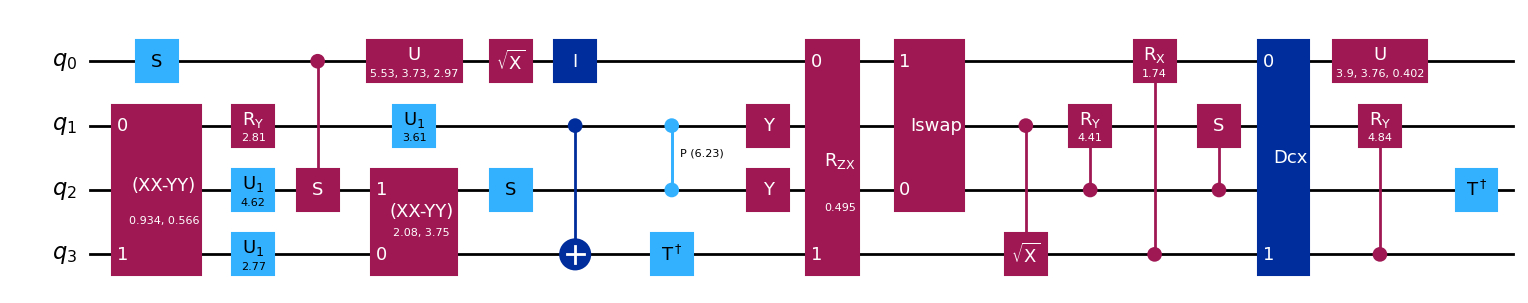

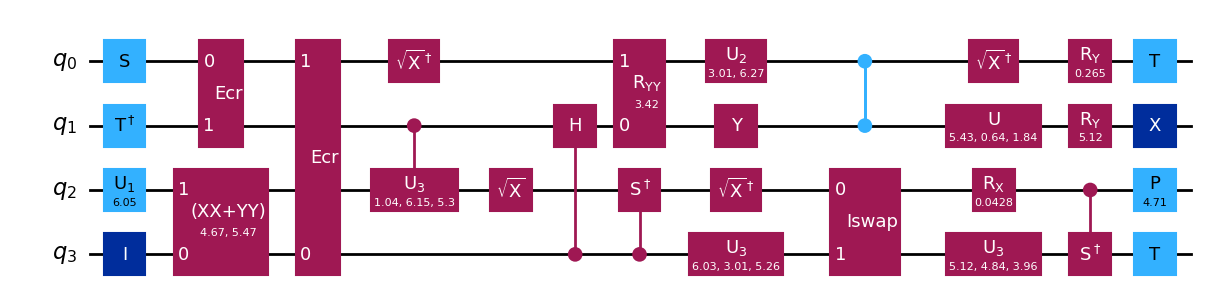

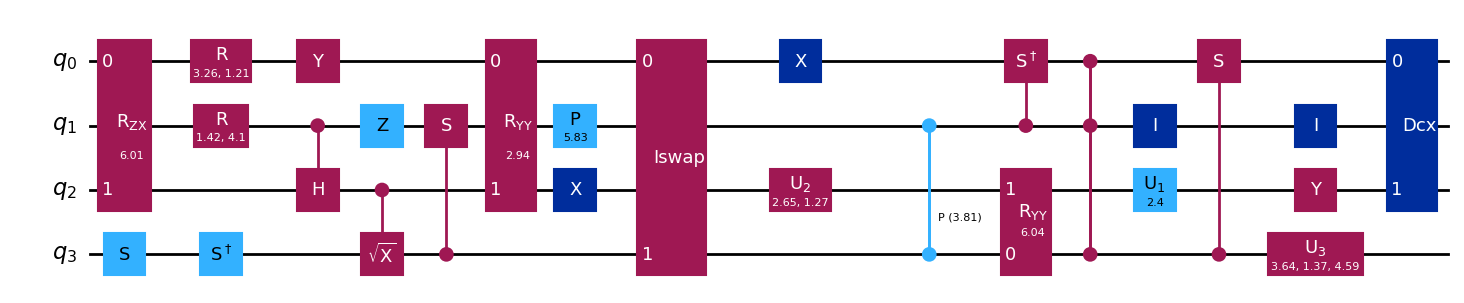

In [398]:
# generating randomized circuits
def generate_seed():

    entropy = secrets.token_bytes(16) + time.time_ns().to_bytes(8, 'big') + uuid.uuid4().bytes
    seed = int(hashlib.sha256(entropy).hexdigest(), 16) % 2**32

    return seed

seeds = []
circuits = []

for i in range(len(groups)): 
    num_wave_functions = len(groups[i][0])

    seed = generate_seed() 
    circuit = random_circuit(num_wave_functions, depth = 10, seed = seed)

    circuits.append(circuit)
    seeds.append(seed)

for i in circuits: 
    display(i.draw('mpl'))

In [399]:
# run above circuits on each group 
# uses statevector simulator backend

simulator = Aer.get_backend('statevector_simulator')
final_wave_functions = []
ancillary_wave_functions = []

def cycle(arr): 
    return [arr[-1]] + arr[:-1]

def run(current_wave_funcs, i):

    result_wave_functions = []

    num_wave_functions = len(current_wave_funcs)

    initial_wave_function = current_wave_funcs[0]

    for wf in current_wave_funcs[1:]:
        initial_wave_function = initial_wave_function.tensor(wf)

    main_circuit = circuits[i]
    initialization_circuit = QuantumCircuit(num_wave_functions)
    initialization_circuit.initialize(initial_wave_function.data, 
                                        [j for j in range(num_wave_functions)])

    full_circuit = initialization_circuit.compose(main_circuit)
    transpiled_circuit = transpile(full_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    final_wave_function = result.get_statevector()
    result_wave_functions.append(final_wave_function)

    return result_wave_functions

final_wave_functions = []

for i in range(len(groups)): 
    wave_functions = groups[i][0]

    ancillary_wave_functions = []
    j = 0 
    while j < len(wave_functions): 
        wave_functions = cycle(wave_functions)
        output_wave_functions = run(wave_functions, i)

        ancillary_wave_functions.append(output_wave_functions)
        j += 1

    final_wave_functions.append(ancillary_wave_functions)

for i in final_wave_functions[0]:
    display(i[0].draw('latex'))

print(len(final_wave_functions))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

8


In [180]:
# get the density matrix for all the outputted
# n-qubit wavefunctions 
density_matrices = []

for i in final_wave_functions: 
    coupled_density_matrices = [] 
    
    for j in range(len(i)): 
        coupled_density_matrices.append(DensityMatrix(i[j][0]))

    density_matrices.append(coupled_density_matrices)

for i in density_matrices: 
    for j in i: 
        display(j.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [181]:
# calculating the fidelities of each quantum state 
# defined by each density matrix, with respect to 
# another randomized statevector

combined_string = ''.join(map(str, seeds))
hash_object = hashlib.sha256(combined_string.encode())
hex_dig = hash_object.hexdigest()[:5]
seed = int(hex_dig, 16)

randomized_pure_state = random_statevector(dims = 2**num_qubits, seed = seed)
randomized_density_matrix = DensityMatrix(randomized_pure_state)

print("Randomized Density Matrix")
display(randomized_density_matrix.draw('latex'))

fidelities = []

def calculate_fidelitiy(rho, sigma): 

    sqrt_rho = sqrtm(rho)
    product = np.dot(sqrt_rho, np.dot(sigma, sqrt_rho))
    sqrt_product = sqrtm(product)
    trace = np.trace(sqrt_product)
    
    return np.real(trace)**2

for coupled_states in density_matrices: 
    coupled_fidelities = []

    for matrix in coupled_states: 

        fidelity = calculate_fidelitiy(matrix, randomized_density_matrix)
        coupled_fidelities.append(fidelity)

    fidelities.append(coupled_fidelities)

print(pd.DataFrame(np.array(fidelities)))


Randomized Density Matrix


<IPython.core.display.Latex object>

          0         1         2         3
0  0.015422  0.027629  0.100214  0.060597
1  0.062218  0.007840  0.068775  0.023414
2  0.002044  0.081829  0.016635  0.084706
3  0.008612  0.134145  0.069518  0.212244
4  0.037048  0.044632  0.160718  0.004203
5  0.045343  0.029661  0.009394  0.022493
6  0.006676  0.004345  0.029112  0.055121
7  0.085769  0.022605  0.149355  0.008571


In [182]:
# convert each fidelity value in a group to a weight
# such that all weights in a group sum to 1

weights = [] 

for values in fidelities: 
    coupled_weights = []
    total = 0 
    for fidelity in values: 
        total += fidelity 

    for fidelity in values: 
        coupled_weights.append(fidelity / total)

    weights.append(coupled_weights) 

# sum of values in each row is 1
print(pd.DataFrame(np.array(weights)))

          0         1         2         3
0  0.075651  0.135527  0.491576  0.297246
1  0.383478  0.048321  0.423890  0.144311
2  0.011037  0.441807  0.089817  0.457339
3  0.020287  0.315993  0.163756  0.499964
4  0.150235  0.180989  0.651733  0.017043
5  0.424196  0.277488  0.087888  0.210428
6  0.070086  0.045611  0.305627  0.578676
7  0.322078  0.084887  0.560850  0.032185


using the new weights, sum up each weight * the density matrix 
it corresponds to in each group to create a new mixed state

$$|\psi_\text{mixed}\rangle \langle \psi_\text{mixed}| = \sum_n \text{weight}_n |\psi_n\rangle \langle \psi_n | $$

In [183]:
mixed_density_matrices = []
 
for coupled_states_idx in range(len(density_matrices)):
    mixed_density_matrix = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)

    for matrix_idx in range(len(density_matrices[coupled_states_idx])):
        current_matrix = density_matrices[coupled_states_idx][matrix_idx].data

        mixed_density_matrix += weights[coupled_states_idx][matrix_idx] * current_matrix


    mixed_density_matrices.append(DensityMatrix(mixed_density_matrix))

for i in mixed_density_matrices: 
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [184]:
# perform spectral/eigendecomposition on the mixed matrices
# each eigenvalue/eigenvector represents the probability/potential pure state
# post-mixed state measurement 

full_eigenvalues, full_eigenvectors = [], []

for matrix in mixed_density_matrices: 

    is_unit_trace = np.isclose(np.trace(matrix), 1.0)
    is_hermitian = np.allclose(matrix, np.matrix(matrix.data).getH())

    # implement checks to ensure the provided density matrix is valid
    if not is_unit_trace: 
        raise Exception("Tr(ρ) ≠ 1")
    if not is_hermitian: 
        raise Exception("ρ not Hermitian")

    eigenvalues, eigenvectors = np.linalg.eigh(matrix.data)
    full_eigenvalues.append([eigenvalues])
    full_eigenvectors.append([eigenvectors])

    reconstructed_matrix = sum(eigenvalues[i] * np.outer(eigenvectors[:, i], 
                                np.conj(eigenvectors[:, i])) for i in range(len(eigenvalues)))

    spectral_decomp_worked = np.allclose(matrix, reconstructed_matrix)

    if not spectral_decomp_worked: 
        raise Exception("spectral decomposition failed")

print(pd.DataFrame(full_eigenvalues))

                                                   0
0  [-6.876618275495383e-17, -3.548538053844179e-1...
1  [-1.8097144109733468e-16, -4.397936858235128e-...
2  [-1.5490979542613692e-16, -7.771258211423604e-...
3  [-7.739296898482365e-17, -5.655038813991793e-1...
4  [-8.124239421041798e-17, -3.4501999255043386e-...
5  [-1.0294691326900423e-16, -6.772490326862911e-...
6  [-8.165590325188811e-17, -4.940510077651491e-1...
7  [-8.687804737388074e-17, -4.2546237685144344e-...


calculate the von-neumann entropy for each mixed_state
using their eigenvalues

$$ S(\rho) = -\sum_n \lambda_n \log(\lambda_n) $$

In [185]:
eigenvalues, eigenvectors = full_eigenvalues, full_eigenvectors

entropies = []

def calculate_entropy(eigenvalues):  

    eigenvalues = np.array(eigenvalues)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 0]

    entropy = -np.sum(non_zero_eigenvalues * np.log(non_zero_eigenvalues))

    return entropy

for eigenlist in eigenvalues: 
    entropies.append(calculate_entropy(eigenlist))

entropies

[1.1555586156223367,
 1.1140831912734372,
 0.9710216247719337,
 1.0583518721813199,
 0.885541470721833,
 1.2485056858498385,
 0.9611814127163506,
 1.0080445521376804]

In [208]:
# organizing the ordering of the mixed states based 
# on the value of their von neumann entropy
# higher entropies have lower indices

sorted_indices = np.argsort(entropies)[::-1]
		
entropies = np.array(entropies)
eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[sorted_indices]

# extracting all the zero eigenvalues that represent impossible states
# to retrieve upon measurement
non_zero_eigenvalue_idxs = []
for eigenlist in eigenvalues: 
    non_zero_eigenvalue_idxs.append(np.where(eigenlist[0] > 1e-10)[0])

organized_eigenvectors = []
statevectors = []

for idx in range(len(eigenvectors)):
    allowed_idxs = non_zero_eigenvalue_idxs[idx]

    organized_eigenvectors.append(eigenvectors[idx][0][allowed_idxs])

for coupled_statevectors in organized_eigenvectors: 
    for statevector in coupled_statevectors: 
        statevectors.append(Statevector(statevector))

for i in statevectors:
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [264]:
# convert the n-dimensional statevectors into 2^n dimensional unit vectors 
# this process is reversible -- the 2^n dimensional unit vectors 
# store the information of the n-dimensional statevectors

def statevector_to_unit_vector(statevector):
    real_parts = np.real(statevector)
    imag_parts = np.imag(statevector)
    combined = np.concatenate([real_parts, imag_parts])
    unit_vector = combined / np.linalg.norm(combined)
    return unit_vector

def unit_vector_to_statevector(unit_vector):
    dim = len(unit_vector) // 2
    real_parts = unit_vector[:dim]
    imag_parts = unit_vector[dim:]
    statevector = real_parts + 1j * imag_parts
    statevector /= np.linalg.norm(statevector)
    return statevector

n_dimensional_unit_vectors = []
statevectors_check = [] 

for i in statevectors: 
    n_dimensional_unit_vectors.append(statevector_to_unit_vector(i))

for i in n_dimensional_unit_vectors: 
    statevectors_check.append(unit_vector_to_statevector(i))

statevectors_check = [Statevector(i) for i in statevectors_check]

if (statevectors_check != statevectors): 
    raise Exception('statevector - unit vector conversion failed!')


In [ ]:
def spherical_harmonics(v, theta, phi):
    l_values = [0, 1, 1, 1]
    m_values = [0, -1, 0, 1]
    result = 0
    for i in range(len(v)):
        l = l_values[i]
        m = m_values[i]
        result += v[i] * sph_harm(m, l, phi, theta).real
    return result

In [240]:
def spherical_harmonics(v, theta, phi):
    
    def generate_l_m(seeds, l_max = 5):
        
        l_values = []
        m_values = []
        
        for seed in seeds:
            random.seed(seed)
            l = random.randint(0, l_max)
            m = random.randint(-l, l)
            l_values.append(l)
            m_values.append(m)
        return l, m

    l_values = [0, 1, 1, 1]
    m_values = [0, -1, 0, 1]
    result = 0
    for i in range(len(v)):
        l = l_values[i]
        m = m_values[i]
        result += v[i] * sph_harm(m, l, phi, theta).real
    return result

In [244]:
len(n_dimensional_unit_vectors)

32

In [245]:
n_dimensional_unit_vectors

[array([-0.01203367, -0.07159678, -0.2656974 , -0.0477702 ,  0.16120014,
        -0.10954674, -0.20955515, -0.04055833,  0.11858856, -0.16000603,
        -0.05179988, -0.06893599, -0.05927245,  0.14616533, -0.1559878 ,
        -0.24277935, -0.11392215, -0.02860106, -0.2722475 ,  0.11333068,
         0.27709318, -0.08396683,  0.05869432,  0.15917889,  0.21259008,
         0.52252873, -0.09339104,  0.07650479,  0.34150893,  0.12894984,
        -0.05797541, -0.0161093 ]),
 array([-0.03151717,  0.03522665,  0.21490785,  0.39945897, -0.26569791,
        -0.20688491,  0.09237721, -0.12114754, -0.14373365,  0.25861903,
         0.25613845,  0.00355156, -0.10027843,  0.07772862, -0.3089353 ,
        -0.12779702,  0.04389361,  0.07567705, -0.05787548,  0.17569991,
         0.01303976,  0.14020067, -0.15192226,  0.20927191, -0.25387475,
         0.01086517, -0.03605567,  0.1581328 ,  0.26232188, -0.11706441,
         0.04023307, -0.26605555]),
 array([-0.06296133, -0.02401381, -0.07946597, -0.11

In [253]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

reduced_data = pca.fit_transform(n_dimensional_unit_vectors)

display(reduced_data)

reconstructed_data = pca.inverse_transform(reduced_data)

display(reconstructed_data)

reconstruction_error = np.mean((n_dimensional_unit_vectors - reconstructed_data) ** 2)
display(reconstruction_error)

array([[-2.00250438e-01,  4.66882606e-01, -7.91517485e-02],
       [ 2.39940417e-01,  1.05563120e-01, -2.88143193e-01],
       [-8.50996020e-02, -3.39661210e-01, -5.49402323e-01],
       [ 4.09294848e-03,  2.59265208e-01, -1.63285576e-02],
       [-3.77264934e-01, -2.18797443e-01, -7.54078665e-01],
       [-3.85023021e-01, -4.55785023e-01,  3.19412680e-01],
       [-3.45812524e-01, -1.30146336e-01,  1.97710426e-01],
       [-2.66103904e-01,  3.50417232e-01,  1.55838136e-01],
       [ 7.78834773e-02, -1.36694309e-01,  5.57098383e-02],
       [ 3.96079980e-01, -7.75680278e-02, -9.65371280e-02],
       [ 3.01863190e-01,  5.50750145e-03,  5.33363428e-01],
       [-3.53217373e-01,  1.50557423e-02,  2.01071729e-01],
       [ 9.74971262e-02, -3.25019001e-02, -3.09301946e-01],
       [ 5.18118670e-01, -1.64871110e-01,  2.35481189e-02],
       [-4.09630618e-01,  2.87880179e-01, -2.68202470e-01],
       [ 1.31421029e-01, -4.69515594e-01,  1.71994890e-01],
       [ 8.86677981e-02, -2.74808486e-01

array([[ 7.03772926e-02, -1.84414822e-03,  5.44211553e-02, ...,
        -8.87157718e-02, -1.02899100e-01, -2.88425418e-02],
       [-1.27783056e-02,  1.11312473e-02,  2.41429596e-02, ...,
        -4.15129663e-02,  3.96186515e-02, -8.00469634e-03],
       [-3.48669138e-02,  5.89334828e-02,  2.51580230e-03, ...,
         3.78727692e-02, -5.50741869e-02, -6.92785965e-02],
       ...,
       [ 1.10083758e-01, -6.21992051e-02, -3.00305518e-02, ...,
        -4.45150611e-02, -2.82307225e-02,  5.12882096e-02],
       [-1.35612876e-02,  3.54494421e-02,  1.28362469e-02, ...,
         3.57236556e-05, -3.19435442e-02, -4.39869667e-02],
       [ 1.37543461e-01, -1.17842867e-02, -6.36733536e-04, ...,
        -2.40997602e-02, -2.32768269e-01, -4.06442403e-02]])

0.02145261747998513

In [257]:
display(pd.DataFrame(reconstructed_data))
display(pd.DataFrame(n_dimensional_unit_vectors))

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.070377,-0.001844,0.054421,0.100823,0.191847,0.032371,-0.035740,-0.080376,-0.121218,-0.028144,...,0.185694,0.070182,0.077288,0.196346,-0.021936,-0.016354,0.186577,-0.088716,-0.102899,-0.028843
1,-0.012778,0.011131,0.024143,0.133395,0.136625,-0.098130,-0.043061,0.088192,-0.011463,0.006517,...,-0.057414,0.051710,-0.110254,0.036160,0.073214,0.011955,0.064196,-0.041513,0.039619,-0.008005
2,-0.034867,0.058933,0.002516,-0.133659,0.151761,-0.356323,-0.092006,-0.094554,0.037331,0.040686,...,-0.096785,0.110576,-0.198668,-0.081637,0.072918,-0.059903,0.013887,0.037873,-0.055074,-0.069279
3,0.054155,-0.014627,0.019993,0.107256,0.107183,0.016536,0.001797,0.029128,-0.058064,-0.016245,...,0.090478,0.012937,0.043395,0.114043,-0.003193,0.008731,0.084275,-0.059924,-0.034833,0.000734
4,-0.034102,0.092852,0.042057,-0.203243,0.270293,-0.425596,-0.162024,-0.267812,-0.021201,0.038943,...,-0.016728,0.206996,-0.210655,-0.022660,0.065357,-0.109343,0.127881,0.024910,-0.149875,-0.124398
5,0.117883,-0.033491,-0.090960,-0.254276,-0.118631,-0.116920,0.110578,-0.062275,0.053868,0.008867,...,0.110616,-0.116073,0.151063,-0.065565,-0.106614,-0.029331,-0.166938,0.066300,-0.140069,0.008280
6,0.106345,-0.023662,-0.041046,-0.137645,-0.012560,-0.060420,0.062322,-0.076771,-0.010003,-0.005237,...,0.148027,-0.053225,0.136165,0.029808,-0.083309,-0.026409,-0.043077,0.012276,-0.134916,-0.005087
7,0.107629,-0.026509,0.018760,0.045911,0.098594,0.073974,0.025171,-0.062389,-0.098379,-0.031502,...,0.219159,-0.001017,0.160100,0.172521,-0.068013,-0.008287,0.108913,-0.067624,-0.119514,-0.005732
8,0.045632,-0.021837,-0.035418,0.006398,-0.009392,-0.065508,0.047698,0.087018,0.029646,0.005249,...,-0.003933,-0.053532,0.014022,-0.015276,-0.002817,0.013945,-0.064700,0.002594,-0.003798,0.019779
9,-0.004716,-0.015650,-0.019119,0.134199,0.021392,-0.066717,0.021673,0.199623,0.045510,0.011165,...,-0.111916,-0.034626,-0.087152,-0.030294,0.064638,0.042129,-0.051242,-0.015170,0.093127,0.032395


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.012034,-0.071597,-0.265697,-0.047770,0.161200,-0.109547,-0.209555,-0.040558,0.118589,-0.160006,...,0.058694,0.159179,0.212590,0.522529,-0.093391,0.076505,0.341509,0.128950,-0.057975,-0.016109
1,-0.031517,0.035227,0.214908,0.399459,-0.265698,-0.206885,0.092377,-0.121148,-0.143734,0.258619,...,-0.151922,0.209272,-0.253875,0.010865,-0.036056,0.158133,0.262322,-0.117064,0.040233,-0.266056
2,-0.062961,-0.024014,-0.079466,-0.118421,0.250626,-0.561522,0.129374,0.090153,-0.074627,0.024412,...,-0.183697,0.330223,-0.029267,-0.156804,0.026213,-0.023654,-0.033580,-0.028390,0.016793,-0.065964
3,0.053530,-0.083072,0.355320,0.308181,0.206827,-0.151699,0.015728,0.143639,-0.073699,-0.039861,...,0.117098,-0.249387,0.066352,0.259789,0.099090,0.100954,0.143594,-0.069262,-0.115420,-0.298897
4,-0.067850,0.036338,0.006981,-0.354515,0.280838,-0.466538,-0.248152,-0.267250,0.023667,-0.060718,...,-0.240400,0.260880,0.018244,-0.118447,0.039840,-0.180407,0.233350,-0.040221,-0.129651,-0.142071
5,0.094745,-0.093945,-0.251661,-0.149456,-0.082945,-0.203554,0.297924,-0.161823,-0.193558,0.065561,...,0.154004,-0.162153,0.057782,-0.015481,-0.046744,-0.042847,-0.046969,0.154047,-0.151865,-0.061916
6,0.135284,-0.036615,-0.255078,-0.149684,0.132233,-0.037893,-0.221221,-0.107124,0.031163,-0.137969,...,0.108525,-0.111284,0.081375,0.020909,-0.286163,0.031149,-0.021011,0.080768,0.108133,0.228140
7,0.205907,0.025876,-0.119976,-0.039177,0.186381,0.227902,-0.197519,0.165502,0.109497,0.233220,...,0.171688,0.167066,0.332324,0.180550,-0.052933,0.075467,-0.060578,-0.049575,-0.247967,-0.131752
8,-0.044826,0.061486,0.243801,-0.267805,0.115162,-0.311353,0.101688,0.530727,0.199797,0.108978,...,0.114474,0.071303,0.097400,0.424004,0.026821,0.038166,-0.068569,-0.007062,-0.034165,0.141785
9,-0.165989,0.080907,-0.218950,0.058348,0.227243,0.122855,0.059003,0.252298,-0.122601,0.011867,...,-0.055624,-0.262048,-0.014757,-0.326993,0.301066,0.082811,-0.101646,0.021724,-0.181281,0.094134


---
---

In [480]:
# generate randomized statevectors for testing 
num_wavefunctions = 32
num_qubits = 3
wave_functions = []

i = 0 
while i < num_wavefunctions: 
    wave_functions.append(random_statevector(dims = 2 ** num_qubits))
    i += 1

groups = []

for i in range(len(wave_functions)):
    group = []
    for j in range(num_qubits):
        group.append(wave_functions[(i + j) % len(wave_functions)])
    groups.append(group)


In [482]:
def generate_seed():

    entropy = secrets.token_bytes(16) + time.time_ns().to_bytes(8, 'big') + uuid.uuid4().bytes
    seed = int(hashlib.sha256(entropy).hexdigest(), 16) % 2**32

    return seed

seeds = []
circuits = []

for i in range(len(wave_functions)): 

    num_wave_functions = num_qubits

    # generate a randomized circuit of a certain depth using 
    # our generated seed
    seed = generate_seed() 
    circuit = random_circuit(num_wave_functions, depth = 10, seed = seed)

    circuits.append(circuit)
    seeds.append(seed)


In [483]:
simulator = Aer.get_backend('statevector_simulator')

In [512]:
def run(wave_func, i):

    result_wf = []
    main_circuit = circuits[i]

    # create a circuit to first prepare the initial_wave_function 
    # from a circuit starting from |0>|0>|0>...
    initialization_circuit = QuantumCircuit(num_qubits)
    initialization_circuit.initialize(wave_func.data, 
                                        [j for j in range(num_qubits)])

    # append the randomized circuit to the initialization_circuit
    full_circuit = initialization_circuit.compose(main_circuit)

    # transpile the circuit onto the simulator backend
    transpiled_circuit = transpile(full_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()

    # output the resultant statevector
    final_wave_function = result.get_statevector()
    result_wf.append(final_wave_function)

    return result_wf


In [513]:
final_wave_functions = []

for i in range(len(groups)): 
    wave_functions = groups[i]
    ancillary_wave_functions = []

    for j in wave_functions: 
        ancillary_wave_functions.append(run(j, i))
    
    final_wave_functions.append(ancillary_wave_functions)
